In [108]:
import numpy as np

# Load data from .npy files
X = np.load("../data/X.npy")  
Y = np.load("../data/Y.npy")

In [109]:
# Define time step (e.g., use the past 50 timesteps to predict the next one)
time_steps = 50

# Create sequences
X_seq, Y_seq = [], []
for i in range(len(X) - time_steps):
    X_seq.append(X[i:i+time_steps])  # 50 time steps as input
    Y_seq.append(Y[i+time_steps])    # The next "Close" price as output

# Convert to NumPy arrays
X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)
Y_seq = Y_seq.reshape(-1, 1)

print("Data reshaping for LSTM completed!")
print("X_seq shape:", X_seq.shape)  # Should be (samples, time_steps, features)
print("Y_seq shape:", Y_seq.shape)  # Should be (samples,)

Data reshaping for LSTM completed!
X_seq shape: (4951, 50, 5)
Y_seq shape: (4951, 1)


In [110]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, X_seq.shape[2])),  
    Dropout(0.2),  # Dropout for regularization
    LSTM(64, return_sequences=False),  
    Dropout(0.2),
    Dense(32, activation='relu'),  
    Dense(1)  # Output layer (Predicting the "Close" price)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

print("✅ LSTM model defined and compiled!")


✅ LSTM model defined and compiled!


c:\Users\chira\OneDrive\Documents\SEM6\CS 354N\ML LEARNING\backtest-and-risk-assessment\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [111]:
# Train the model
history = model.fit(X_seq, Y_seq, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

print("✅ Model training completed!")


Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0286 - val_loss: 0.0014
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 9.4150e-04 - val_loss: 0.0015
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 9.3652e-04 - val_loss: 0.0019
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 8.9679e-04 - val_loss: 0.0012
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 6.8809e-04 - val_loss: 0.0021
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 6.5951e-04 - val_loss: 0.0018
Epoch 11/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 6.1437e-04 - val_loss: 0.0026
Epoch 12/50
140/1

In [22]:
# Save the trained LSTM model
model.save("../models/lstm_model.h5")

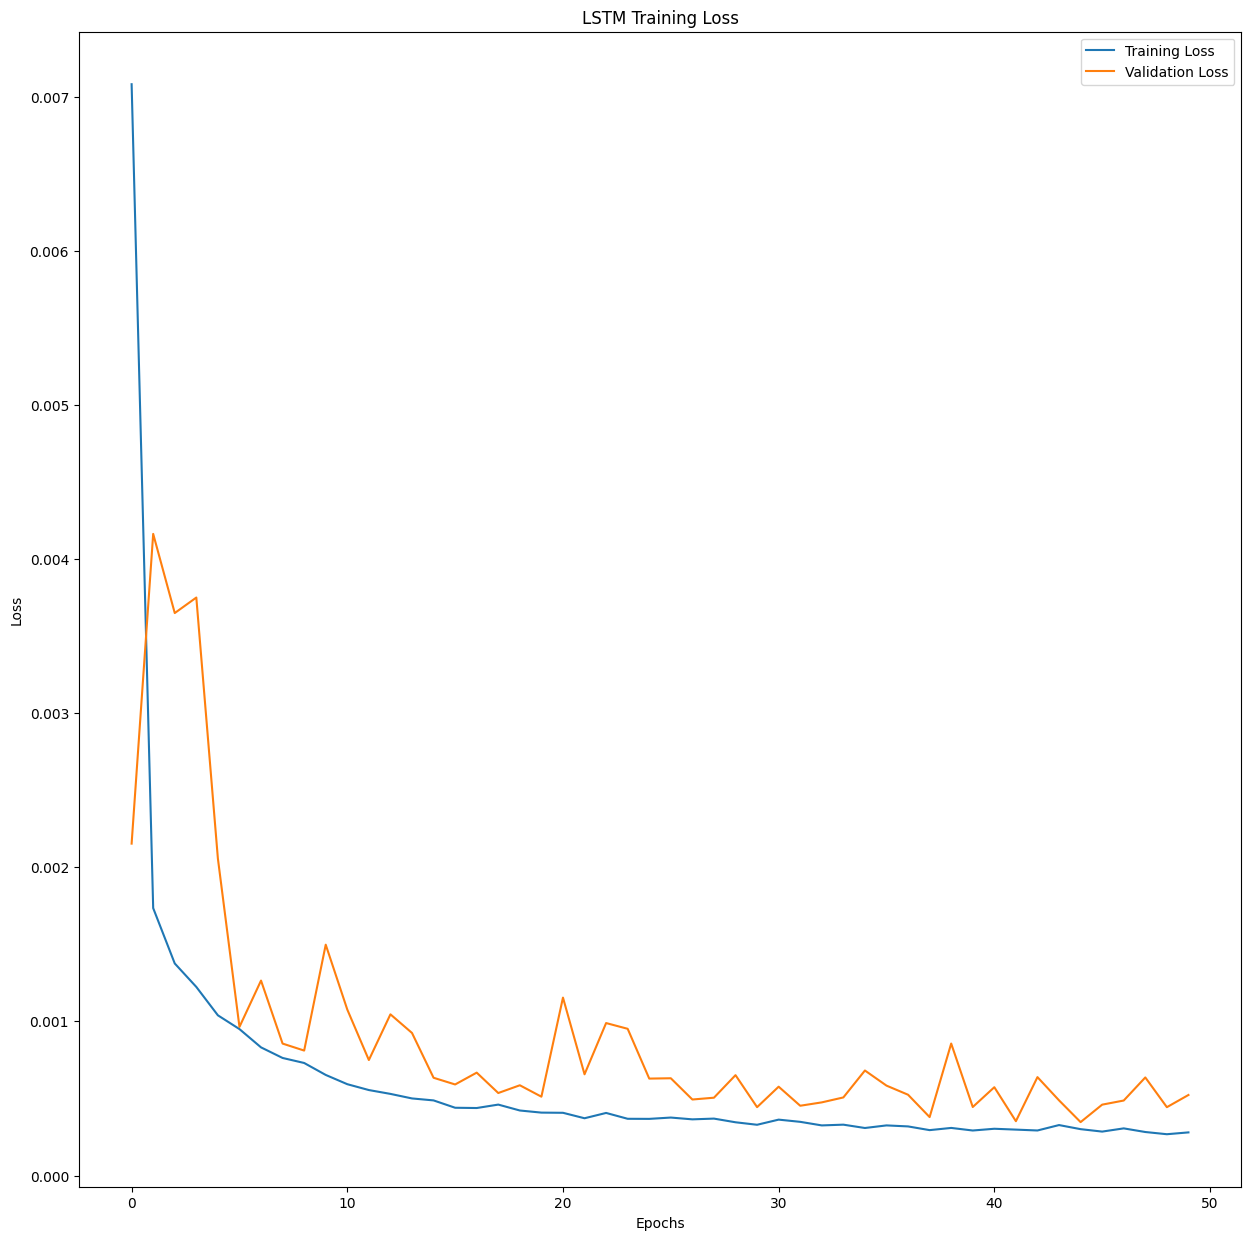

In [23]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()


In [92]:
train_predictions = model.predict(X_seq)  # Predict using LSTM

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [93]:
import joblib

# Load the saved scaler
scaler = joblib.load("../models/scaler.pkl")

In [ ]:
# Inverse transform the predictions
# Extract only the Close column
train_predictions = scaler.inverse_transform(
    np.concatenate((np.zeros((len(train_predictions), 3)),  
                    train_predictions.reshape(-1, 1),
                    np.zeros((len(train_predictions), 1))),  
                   axis=1)  
)[:, 3]  

# Inverse transform actual prices
actual_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((len(Y_seq), 3)),  
                    Y_seq.reshape(-1, 1),
                    np.zeros((len(Y_seq), 1))),  
                   axis=1)
)[:, 3]

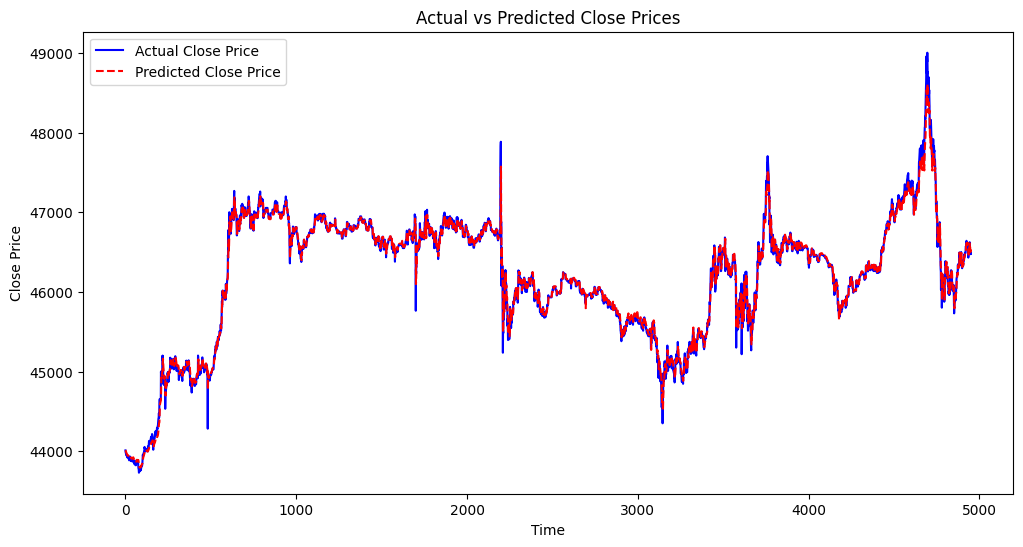

In [105]:
# plot the given Actual Close Price and Predicted Close Price:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Close Price", color="blue")
plt.plot(train_predictions, label="Predicted Close Price", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.title("Actual vs Predicted Close Prices")
plt.show()


In [97]:

print("First 10 actual prices from Y_seq :", actual_prices[:10])
actual_close_prices_from_csv = df["Close"].values[50:]
print("First 10 actual prices from CSV:", actual_close_prices_from_csv[:10])


First 10 actual prices from Y_seq : [44012.  43993.5 43979.  43978.5 43978.5 43952.  43957.  43957.  43957.
 43935.5]
First 10 actual prices from CSV: [44012.  43993.5 43979.  43978.5 43978.5 43952.  43957.  43957.  43957.
 43935.5]
